# Objective 1 Working Process

This notebook may contain duplicate functions or code because its main purpose is to showcase the group's thought process in completing this task, including data preprocessing, model selection, and parameter tuning.

To highlight the key points, we will first showcase the training and hyperparameter tuning process of the final selected model, along with the encountered issues. Then, we will present the thought process in details behind our approach.

In [ ]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset,random_split, Dataset
from torchvision import transforms
from other.objective0 import DataPreparation, WildFireDataset
from sklearn.model_selection import train_test_split
import random
from sklearn.metrics import mean_squared_error
from skimage.filters import threshold_otsu
from sklearn.decomposition import PCA
from numpy.linalg import inv

## Convolutional LSTM (Version 2)

Because its results are the best, we choose this model, which is similar to the model used in the ACDS2.

While preprocessing the data, we noticed that the 12,500 data points in the training set did not correspond to 12,500 instances of the same wildfire but encompassed various wildfire occurrences. To ensure compatibility with loading background and observation data (and potentially unknown datasets) later on, I created another custom Dataset class `WirefireDatasetImage` specifically tailored to this objective. It reads `.npy` files from specified paths, partitions the data into different wildfire categories based on certain rules (instead of strictly specifying each 100 data points as one wildfire), and generates input sequences and output sequences. Subsequent sequences with identical values are discarded. Since training the model directly with the original 256x256 data would be time-consuming, we resized the data to a smaller size.

While experimenting with a simple LSTM, I adjusted the number and size of LSTM and fully connected layers, added or removed batch normalization and dropout layers. The best performance was achieved with a single LSTM layer and fully connected layers of size 32 -> 256 -> 256x256. Although the MSE decreased, the generated images still exhibited similar issues to those of a regular RNN, with blurriness and lack of resemblance.

Drawing parallels with the storm image generation task from ACDS2, we considered using a Convolutional LSTM model.

Another challenge in handling time-series data is determining the sequence length and sliding window size (i.e., how often to take a sequence). If the sequence length is set to 4, i.e., using 4 images to predict the next one, in objective 3, there might be situations where only one predicted image is available, resulting in R and B matrices of size 1x1. Therefore, we decided to set the sequence length to 2 to maximize the training data, with a sliding window size of 1.

During the initial training phase, although the MSE between predicted and original results was low, the generated images closely resembled the previous time step's original images, indicating that the model was essentially learning the data from the previous time step without capturing the dynamic process of the sequence. After adjusting the model structure, overfitting became apparent (training loss steadily decreased while validation loss oscillated, or both remained stable). Consequently, we gradually adjusted parameters such as hidden channels, number of layers, and learning rate. Plus, when resizing images to 64, while training time reduced and MSE differences were negligible, the resulting images after interpolation back to the original size (64x64) appeared significantly blurry compared to those resized to 128x128. Therefore, our final selection includes:

- `hidden_channels=16`
- `kernel_size=(3, 3)`
- `padding=(1, 1)`
- `activation="relu"`
- `frame_size=(128, 128)`
- `num_layers=2`

Additionally, we finally use Binary Cross Entropy (BCE) Loss rather than Mean Squared Error (MSE) Loss. Because for binary image data (where pixel values are either 0 or 1):

- Interpretability: BCE Loss is more interpretable in the context of binary classification tasks. It directly measures the dissimilarity between the predicted probabilities and the ground truth labels for each pixel, making it more intuitive to interpret.

- Gradient Magnitude: BCE Loss tends to produce larger gradient magnitudes compared to MSE Loss, especially when the predicted probabilities are far from the ground truth. This can lead to more efficient and stable optimization, especially in the case of binary classification problems.

- Sensitivity to Misclassifications: BCE Loss penalizes misclassifications more heavily than MSE Loss, especially when the predicted probabilities are close to the opposite class. This can be beneficial in tasks where correctly predicting one class (e.g., presence of wildfire) is more critical than the other.

- Scale Invariance: BCE Loss is scale-invariant, meaning it is not affected by the absolute magnitude of the predicted probabilities. This property is advantageous when dealing with binary data where the pixel values are constrained to a specific range (0 or 1), as it ensures that the loss function is not overly sensitive to the scale of the predictions.

We also add Structural Similarity Index Measure (SSIM) to evaluate the results.

SSIM compares the structural similarity between two images rather than just the pixel-wise difference. It takes into account luminance, contrast, and structure, which are important factors in human perception of image quality. SSIM is more aligned with human perception compared to MSE, as it considers how humans perceive images rather than just focusing on pixel values.

The reasons why we use MSE and SSIM together to evaluate the outputs are:

- Comprehensive evaluation:
  - MSE focuses solely on pixel-wise differences, while SSIM incorporates structural similarity. Using both metrics together provides a more comprehensive evaluation of image quality. While MSE captures the pixel-wise errors, SSIM captures the perceptual differences, giving a more holistic view of quality.

- Balanced assessment:
  - MSE tends to be more sensitive to large errors, while SSIM is sensitive to perceptual changes. Combining both metrics balances these sensitivities, providing a more balanced assessment of image quality. This can help in cases where both pixel-wise accuracy and perceptual fidelity are important.

- Suitability for different applications:
  - Different applications may prioritize different aspects of image quality. For applications where pixel-wise accuracy is crucial, MSE might be more important. In contrast, for applications where human perception is key (such as image compression or enhancement), SSIM might be more relevant. Using both allows for tailoring the evaluation to the specific requirements of the application.

In [ ]:
class ConvLSTMCell(nn.Module):
    def __init__(self,
                 input_channels,
                 output_channels,
                 kernel_size,
                 padding,
                 activation,
                 frame_size):
        super(ConvLSTMCell, self).__init__()

        if activation == 'tanh':
            self.activation = nn.Tanh()
        elif activation == 'relu':
            self.activation = nn.ReLU()

        self.conv = nn.Conv2d(input_channels+output_channels,
                              4*output_channels,
                              kernel_size,
                              padding=padding)

        # initialize the weights
        self.W_ci = nn.Parameter(torch.Tensor(output_channels, *frame_size))
        self.W_co = nn.Parameter(torch.Tensor(output_channels, *frame_size))
        self.W_cf = nn.Parameter(torch.Tensor(output_channels, *frame_size))

    def forward(self, input_tensor, H_prev, C_prev):
        # Idea adapted from https://github.com/ndrplz/ConvLSTM_pytorch
        conv_output = self.conv(torch.cat([input_tensor, H_prev], dim=1))
        i_conv, f_conv, C_conv, o_conv = torch.chunk(conv_output, chunks=4, dim=1)

        input_gate = torch.sigmoid(i_conv + self.W_ci * C_prev)
        forget_gate = torch.sigmoid(f_conv + self.W_cf * C_prev)

        C_out = forget_gate * C_prev + input_gate * self.activation(C_conv)
        output_gate = torch.sigmoid(o_conv + self.W_co * C_out)

        H_out = output_gate * self.activation(C_out)

        return H_out, C_out

class ConvLSTM(nn.Module):
    def __init__(self,
                 input_channels,
                 output_channels,
                 kernel_size,
                 padding,
                 activation,
                 frame_size):
        super(ConvLSTM, self).__init__()
        self.output_channels = output_channels
        self.conv_lstm_cell = ConvLSTMCell(input_channels, output_channels, kernel_size,
                                           padding, activation, frame_size)

    def forward(self, input_tensor):
        # input_tensor: (batch_size, input_channels, seq_len, height, width)
        batch_size, _, seq_len, height, width = input_tensor.size()

        output = torch.zeros(batch_size, self.output_channels, seq_len, height, width,
                             device=device)

        H = torch.zeros(batch_size, self.output_channels, height, width, device=device)
        C = torch.zeros(batch_size, self.output_channels, height, width, device=device)

        for t in range(seq_len):
            H, C = self.conv_lstm_cell(input_tensor[:, :, t], H, C)
            output[:, :, t] = H

        return output

class ConvLSTMModel(nn.Module):
    def __init__(self,
                 input_channels,
                 hidden_channels,
                 kernel_size,
                 padding,
                 activation,
                 frame_size,
                 num_layers):
        super(ConvLSTMModel, self).__init__()

        self.sequential = nn.Sequential()

        self.sequential.add_module('conv_lstm_0',
                                   ConvLSTM(input_channels, hidden_channels, kernel_size,
                                            padding, activation, frame_size))
        self.sequential.add_module('batch_norm_0',
                                   nn.BatchNorm3d(hidden_channels))

        for i in range(1, num_layers):
            self.sequential.add_module(f'conv_lstm_{i}',
                                       ConvLSTM(hidden_channels, hidden_channels, kernel_size,
                                                padding, activation, frame_size))
            self.sequential.add_module(f'batch_norm_{i}',
                                       nn.BatchNorm3d(hidden_channels))

        self.conv = nn.Conv2d(hidden_channels, input_channels, kernel_size, padding=padding)

    def forward(self, x):
        x = self.sequential(x)
        x = self.conv(x[:, :, -1])
        return nn.Sigmoid()(x)
    

In [ ]:
model = ConvLSTMModel(input_channels=1, hidden_channels=16, kernel_size=(3,3), padding=(1,1), activation="relu",
                     frame_size=(128, 128), num_layers=2).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

## Other Thought Process

### Prepare the Data

In the beginning, we used 4 images to predict the 5th image, so the sequence length is 4.

In [ ]:
# load the data using the DataPreparation class
data_prep = DataPreparation(train_path='Ferguson_fire_train.npy', test_path='Ferguson_fire_test.npy')
# separate the data by different wildfire kinds and return lists
train_wildfires, test_wildfires = data_prep.separate_and_filter_datas()

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])

# create the dataset
train_dataset = WildFireDataset(train_wildfires, transform=transform)
test_dataset = WildFireDataset(test_wildfires, transform=transform)

# split the train dataset into train and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# create the dataloader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


### RNN(Baseline)

Before applying a complicated model, we constructed a simple RNN to gauge its performance as a preliminary exploration. This approach allows us to establish a baseline understanding of the problem space and provides insights into how well a basic model captures the underlying patterns in the data. Additionally, starting with a simple model helps us identify any fundamental challenges or limitations early in the process, which can inform our subsequent modeling decisions and potentially guide us towards more effective and efficient solutions.

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, input_shape):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size=input_shape[1] * input_shape[2], hidden_size=64, batch_first=True)
        self.dense = nn.Linear(64, input_shape[1] * input_shape[2])
        self.sigmoid = nn.Sigmoid()
        self.reshape = input_shape[1], input_shape[2]

    def forward(self, x):
        batch_size, time_steps, _ = x.size()
        x, _ = self.rnn(x)
        x = self.dense(x[:, -1, :])  # Use the output of the last time step
        x = self.sigmoid(x)
        x = x.view(batch_size, self.reshape[0], self.reshape[1])  # Reshape to the original image shape (256, 256)
        return x

def build_rnn_model(input_shape):
    return RNNModel(input_shape)

#### Training the Model

In [ ]:
def train_model(model, train_loader, input_shape, lr, num_epochs, device, model_path):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets.view_as(outputs))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    torch.save(model.state_dict(), model_path)

In [ ]:
input_shape = (4, 256, 256)
lr = 0.001
num_epochs = 10
model_path = 'wildfire_rnn_model.pth'
device = torch.device("mps") if torch.has_mps else torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = build_rnn_model(input_shape).to(device)
train_model(model, train_loader, input_shape, lr, num_epochs, device, model_path)

train_data shape: (12500, 256, 256)
input_shape: (4, 256, 256)
Epoch [1/10], Loss: 0.0615
Epoch [2/10], Loss: 0.0332
Epoch [3/10], Loss: 0.0290
Epoch [4/10], Loss: 0.0271
Epoch [5/10], Loss: 0.0260
Epoch [6/10], Loss: 0.0251
Epoch [7/10], Loss: 0.0246
Epoch [8/10], Loss: 0.0238
Epoch [9/10], Loss: 0.0222
Epoch [10/10], Loss: 0.0207


#### Result

Mean Squared Error between predict and obs: 0.09871006079761382
Mean Squared Error between background and obs: 0.1185455322265625
Mean Squared Error between background and predict: 0.05105043202638626


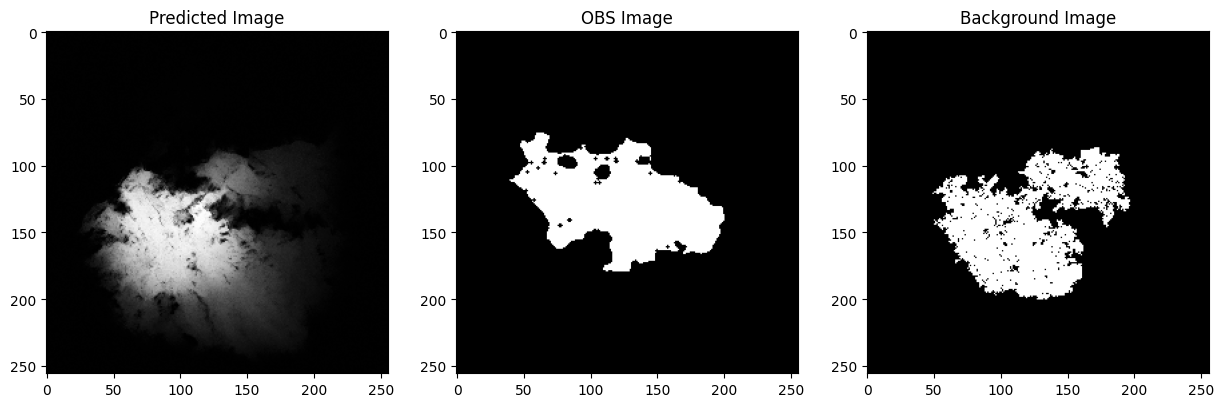

In [ ]:
input_shape = (4, 256, 256)  
model = build_rnn_model(input_shape)
model.load_state_dict(torch.load('wildfire_rnn_model.pth'))
model.eval()
background = np.load('Ferguson_fire_background.npy')
obs = np.load('Ferguson_fire_obs.npy')

input_data = background[:4].reshape((1, 4, background.shape[1] * background.shape[2]))
input_tensor = torch.tensor(input_data, dtype=torch.float32)

# predict the 5th image
with torch.no_grad():
    predicted_image = model(input_tensor).numpy()

# print mses
predicted_image_reshaped = predicted_image.reshape(background.shape[1], background.shape[2])
mse_pred_obs = mean_squared_error(obs[4].flatten(), predicted_image_reshaped.flatten())
mse_bg_obs = mean_squared_error(background[4].flatten(), obs[4].flatten())
mse_back_back_pred = mean_squared_error(background[4].flatten(), predicted_image_reshaped.flatten())
print(f'Mean Squared Error between predict and obs: {mse_pred_obs}')
print(f'Mean Squared Error between background and obs: {mse_bg_obs}')
print(f'Mean Squared Error between background and predict: {mse_back_back_pred}')

# draw the images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(predicted_image_reshaped, cmap='gray')
axes[0].set_title('Predicted Image')

axes[1].imshow(obs[4], cmap='gray')
axes[1].set_title('OBS Image')

axes[2].imshow(background[4], cmap='gray')
axes[2].set_title('Background Image')

plt.show()

The results are not bad, as they slightly reduce the MSE, indicating that the direction of using RNN is correct. However, the generated images are very blurry. In this model, we use 4 images in the background sequence to predict the last image in the background image. Then compare the results with the last image of background as well as observation data. The mean square error between background data and prediction is smaller than the observation data and the prediction, meaning the prediction image is more similar to the background data. 

Because the original image pixel values were only 0 and 1, we wrote a function to set a threshold, forcibly converting the predicted data values to 0 and 1. And compare the new binary image with true image again.

Automatically found threshold: 0.3459935784339905
Mean Squared Error: 0.1330108642578125
(256, 256)


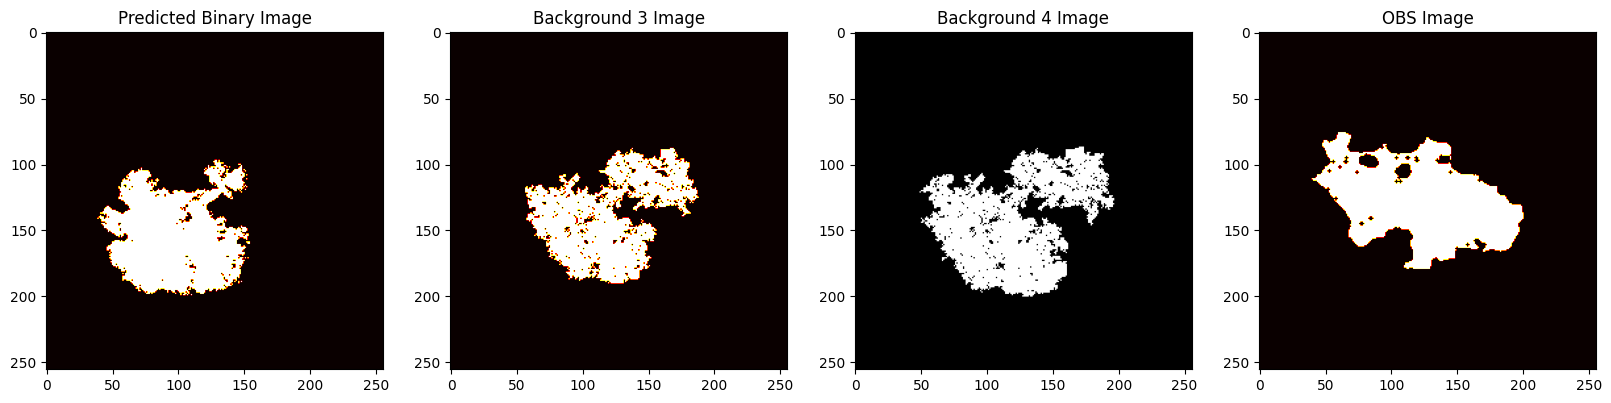

In [ ]:
# find the optimal threshold value using Otsu's method
def binarize_image_otsu(image):
    threshold = threshold_otsu(image)
    binary_image = np.where(image > threshold, 1, 0)
    return binary_image, threshold

binary_predicted_image, threshold = binarize_image_otsu(predicted_image)
print(f'Automatically found threshold: {threshold}')

mse = mean_squared_error(obs[4].flatten(), binary_predicted_image.flatten())
print(f'Mean Squared Error: {mse}')

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
print(obs[4].shape)
axes[0].imshow(binary_predicted_image.reshape(256,256), cmap='hot')
axes[0].set_title('Predicted Binary Image')

axes[3].imshow(obs[4], cmap='hot')
axes[3].set_title('OBS Image')

axes[1].imshow(background[3], cmap='hot')
axes[1].set_title('Background 3 Image')

axes[2].imshow(background[4], cmap='gray')
axes[2].set_title('Background 4 Image')

plt.show()

We could use the MSE errors before binarizing as the baseline for the following trials we are going to do. After binarizing the image, we could see the mse error increased although it makes easier for people to observe. For threshold of binarizing image, we used otsu method to find the suitable threshold, hypter tuning the threshold could result in variance output image, which may lead to differnece in the result of data assimilation.

### CAE + Attention + LSTM

Considering the paper provided in previous model (Data assimilation in the latent space of a neural network. arXiv preprint arXiv:2012.12056.), which illustrated the method of using CAE LSTM to conduct data compression and assimilation after training the model. We also introduced attention mechanism here, instead of using Conv LSTM structure, there are two reasons behind that:
1. The CAE is already compressing the image information into latent space, using Conv layers in LSTM could only make replicated works and slowing down the training speed and making redundant components in the model.
2. The attention mechanism could work together with LSTM, improving the ability to capture long-distance dependencies. The Attention mechanism can directly access all positions of the input sequence and is not limited by the length of the sequence. Although LSTM can capture long-distance dependencies, its effect will attenuate as the distance increases.
3. The attention mechanism enhanced the interpretability of the model. The Attention mechanism makes the decision-making process of the model more transparent, and you can clearly see which parts of the input sequence the model pays attention to when processing a certain output.

There are two structures of CAE LSTM that have been tried in this project, the main difference between them are the CAE latent space. The following model used linear layer to form the latent space, creating 1D latent space for CAE model, making it easier for the data assimilation to be processed in 1D. Another structure is avoid using linear layers in CAE, resulting in 2D latent space for data assimilation, we are going to compare the assimilation result in the following cells and make a suggestion on the model structure.

#### Defining and training the model (dedicated for DA)

In [ ]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        self.attn = nn.Linear(hidden_size, hidden_size)
        self.softmax = nn.Softmax(dim=1)
        self.tanh = nn.Tanh()

    def forward(self, hidden, encoder_outputs):
        hidden_expanded = hidden.unsqueeze(1).expand(-1, encoder_outputs.size(1), -1)
        attn_energies = torch.sum(self.tanh(self.attn(hidden_expanded) + encoder_outputs), dim=2)
        attn_weights = self.softmax(attn_energies).unsqueeze(2)
        context = torch.sum(attn_weights * encoder_outputs, dim=1)
        return context

class AttnLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(AttnLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.attn = Attention(hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out_attn = []
        for t in range(out.size(1)):
            context = self.attn(out[:, t, :], out)
            out_attn.append(context.unsqueeze(1))
        out_attn = torch.cat(out_attn, dim=1)
        out = self.fc(out_attn)
        return out

class CAE(nn.Module):
    def __init__(self):
        super(CAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # -> (batch, 16, 128, 128)
            nn.ReLU(True),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # -> (batch, 32, 64, 64)
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # -> (batch, 64, 32, 32)
            nn.ReLU(True),
            nn.Flatten(),  # -> (batch, 64*32*32)
            nn.Linear(64*32*32, 1024),  # -> (batch, 1024)
            nn.ReLU()
            
        )
        self.decoder = nn.Sequential(
            nn.Linear(1024, 64*32*32),  # -> (batch, 64*32*32)
            nn.ReLU(True),
            nn.Unflatten(1, (64, 32, 32)),  # -> (batch, 64, 32, 32)
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # -> (batch, 32, 64, 64)
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # -> (batch, 16, 128, 128)
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # -> (batch, 1, 256, 256)
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

class CAEAttnLSTM(nn.Module):
    def __init__(self, input_shape, lstm_hidden_size):
        super(CAEAttnLSTM, self).__init__()
        self.cae = CAE()
        self.lstm_hidden_size = lstm_hidden_size
        self.encoded_size = 1024  # make sure it is the size as the cae output
        self.lstm = AttnLSTM(input_size=self.encoded_size,
                             hidden_size=lstm_hidden_size,
                             output_size=self.encoded_size)

    def forward(self, x):
        batch_size, time_steps, _, _ = x.size()
        #print(f"Input shape: {x.shape}")
        x = x.view(batch_size * time_steps, 1, 256, 256)
        features = self.cae.encoder(x)
        features = features.view(batch_size, time_steps, -1)

        lstm_out = self.lstm(features)
        lstm_out = lstm_out.contiguous().view(batch_size, time_steps, -1)

        out = self.cae.decoder(lstm_out[:, -1, :].contiguous().reshape(batch_size, -1))
        out = out.view(batch_size, 1, 256, 256)
        return out


We used flatten because we have to use a latent space that is small and able to capture the most important features of the input data, so that we could create a moderate sized covariance matrix and do data assimilation. The initial version of the CAE LSTM is to use CAE to create 2D latent data. The original structure, however, did not compress the model data efficiently into latent space, the actual latent size (32 $\times$ 64 $\times$ 64) is the same the image size (256 $\times$ 256).

In [ ]:
input_shape = (4, 256, 256)
lstm_hidden_size = 512
lr = 0.001
num_epochs = 10
model_path = 'newstruct_stand_cae_attn_lstm_model.pth'
device = torch.device("mps") if torch.has_mps else torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CAEAttnLSTM(input_shape, lstm_hidden_size).to(device)

train_model(train_loader, input_shape, lstm_hidden_size, lr, num_epochs, device, model_path)

Epoch [1/10], Loss: 0.0583
Epoch [2/10], Loss: 0.0283
Epoch [3/10], Loss: 0.0161
Epoch [4/10], Loss: 0.0141
Epoch [5/10], Loss: 0.0133
Epoch [6/10], Loss: 0.0128
Epoch [7/10], Loss: 0.0125
Epoch [8/10], Loss: 0.0120
Epoch [9/10], Loss: 0.0116
Epoch [10/10], Loss: 0.0112


In [ ]:
def load_model_and_data(model_path, input_shape, lstm_hidden_size=128):
    
    model = CAEAttnLSTM(input_shape, lstm_hidden_size)
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()

    background = np.load('Ferguson_fire_background.npy')
    obs = np.load('Ferguson_fire_obs.npy')

    return model, background, obs

def predict_and_evaluate(model, background, obs,save = False):
    input_data = background[:4].reshape((1, 4, 256, 256))
    input_tensor = torch.tensor(input_data, dtype=torch.float32)

    with torch.no_grad():
        
        predicted_image = model(input_tensor)
        predicted_image = predicted_image.squeeze().numpy()  

    
    mse_pred_obs = mean_squared_error(obs[4].flatten(), predicted_image.flatten())
    mse_bg_obs = mean_squared_error(background[4].flatten(), obs[4].flatten())
    mse_bg_pred = mean_squared_error(background[4].flatten(), predicted_image.flatten())
    print(f'Mean Squared Error between predict and obs: {mse_pred_obs}')
    print(f'Mean Squared Error between background and obs: {mse_bg_obs}')
    print(f'Mean Squared Error between background and predict: {mse_bg_pred}')

    threshold = threshold_otsu(predicted_image)
    binary_predicted_image = predicted_image > threshold
    mse_otsu = mean_squared_error(obs[4].flatten(), binary_predicted_image.flatten())
    print(f'Mean Squared Error between binary predict and obs: {mse_otsu}')

    print(f'Otsu threshold: {threshold}')

    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    axes[0].imshow(predicted_image, cmap='gray')
    axes[0].set_title('Predicted Image')

    axes[1].imshow(binary_predicted_image, cmap='gray')
    axes[1].set_title('Binary Predicted Image')

    axes[2].imshow(obs[4], cmap='gray')
    axes[2].set_title('OBS Image')

    axes[3].imshow(background[4], cmap='gray')
    axes[3].set_title('Background Image')

    plt.show()

    if save:
        output_path = 'predicted_image.npy'
        np.save(output_path, predicted_image)
        print(f'Predicted image saved to {output_path}')
    

def predict_and_plot(model_path, input_shape, lstm_hidden_size=128):
    model, background, obs = load_model_and_data(model_path, input_shape, lstm_hidden_size)
    predict_and_evaluate(model, background, obs)

We are going to test the model performance based on different hidden size of LSTM cell. We will discuss the results and determine the most suitable hidden size of the lstm cell.

##### The result of 128 hidden size

Mean Squared Error between predict and obs: 0.10388535857958857
Mean Squared Error between background and obs: 0.1185455322265625
Mean Squared Error between background and predict: 0.023785363882780075
Mean Squared Error between binary predict and obs: 0.1205291748046875
Otsu threshold: 0.44335615634918213


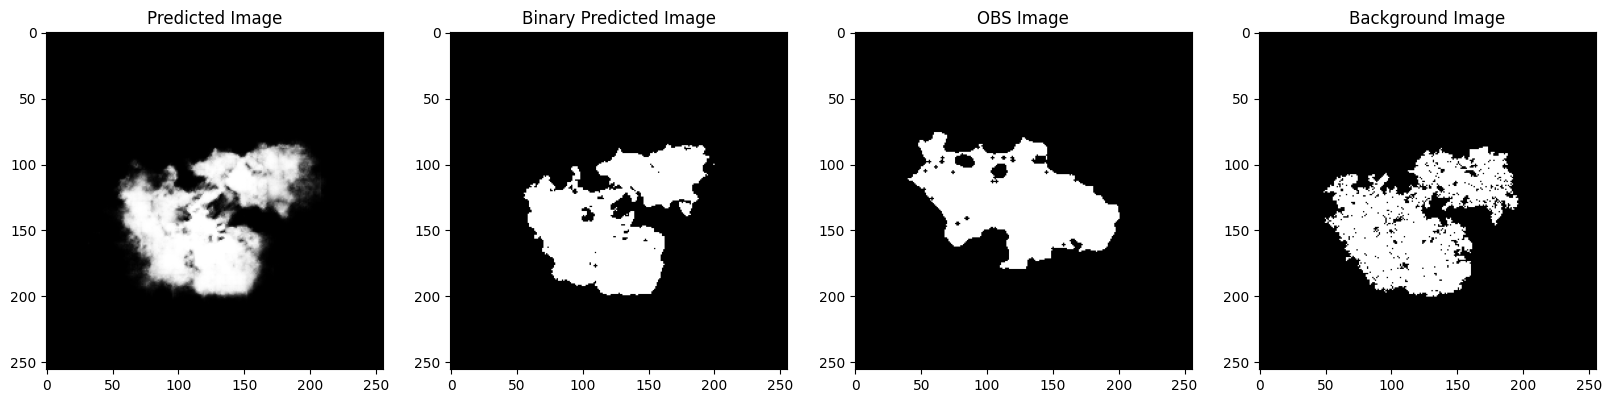

In [ ]:
model_path = 'newstruct_stand_cae_attn_lstm_model.pth'
input_shape = (4, 256, 256)
lstm_hidden_size = 128
predict_and_plot(model_path, input_shape, lstm_hidden_size)

Let's firstly analyse the image output of the prediction model. The predicted image is blurred around its edges, which is the result of using CAE to extract information and reconstruct information of the original binarised image. Therefore, the output of the prediction will be images with pixel valued between 0 and 1, instead of exactly 1 and 0. We could transform this image into binary and compare the result with the corresponding background image to see if the model is predicting the correct results for the last image in the sequence. From human eye observation, the binary prediction image are similar to the background in majority pixels, only the pixels around the upper left is not as exact as the real image, this is because there are numerous black areas enclosed by the image around that area. Because the CAE model is not sufficient to extract information with such precision. 

Then, comparing the mean square error with the baseline model, the predicted image is now more similar to the background data, which is what we expected for, we could utilize this value to compare against other models that are going to be tested in this notebook.

##### The result of 512 hidden size

Mean Squared Error between predict and obs: 0.09293387939088364
Mean Squared Error between background and obs: 0.1185455322265625
Mean Squared Error between background and predict: 0.058647092431783676
Mean Squared Error between binary predict and obs: 0.1320343017578125
Otsu threshold: 0.20130041241645813


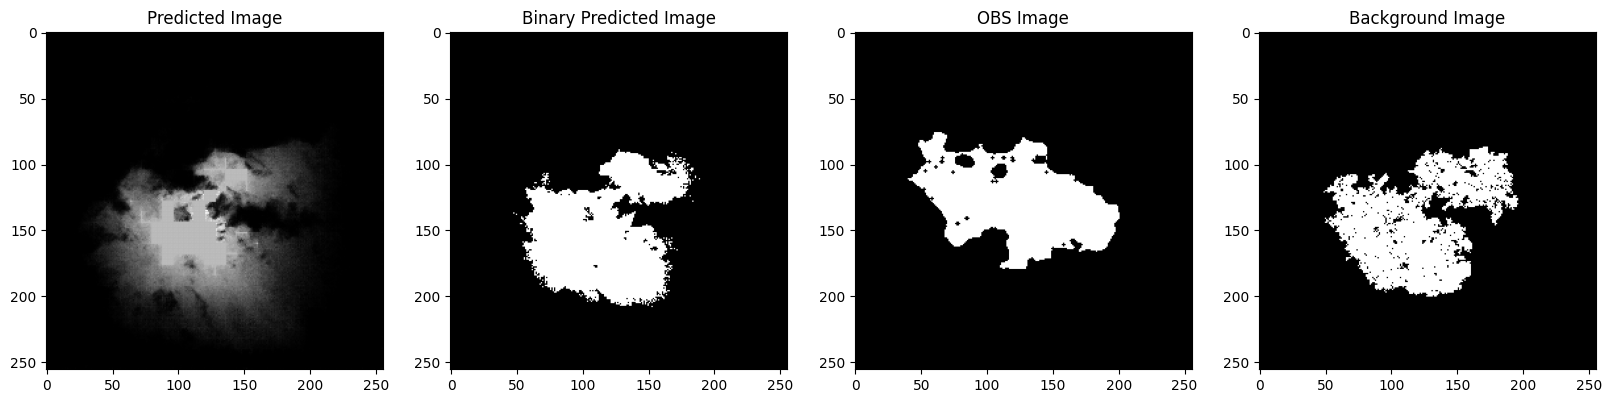

In [ ]:
model_path = 'newstruct_512_cae_attn_lstm_model.pth'
input_shape = (4, 256, 256)
lstm_hidden_size = 512
predict_and_plot(model_path, input_shape, lstm_hidden_size)

It is expected that larger latent dimension of the lstm layer could retain more information and yield smaller mse. However, the result is not as expected because increase in latent space dimension will also lead to potential overfitting the result, and the output image is also more blurred compared with the result of 128 dimension in LSTM latent space.  

Another point worth mentioning is the mse value between prediction and corresponding observation iamge is lower when the dimension size is 512. This probably is caused by the blurred pixel value in the prediction image, because the gray value in the image indicates a smaller value, calculating mse with such small values could lead to a smaller mse, yet the blur image with such image quality is not tolerable for data assimmilation tasks later on. Also not suitable for reconstructing image back from the latent space in the CAE. Thus, it is better to use binary prediction result when conducting data assimilation with a separate data compression method, or otherwise, conduct binarization to the output of the assimilation results. 

In conclusion, I believe using 128 dimension in LSTM latent space is a better choice by referring to the lower mse value in comparing the prediction result with the corresponding background image, and the observation conclusion from human eye. Then we could conduct data assimilation in this model. 

Latent MSE before DA: 12.056478
Latent MSE after DA: 0.02598238


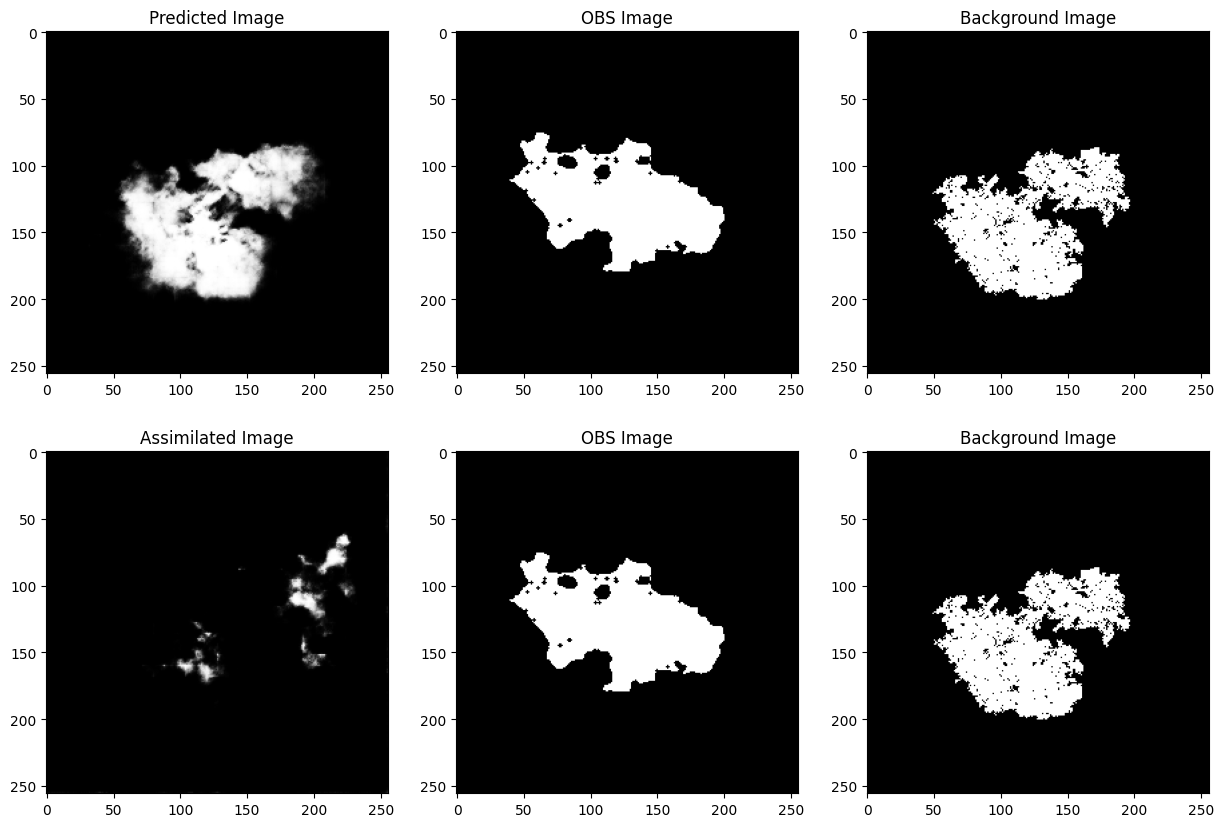

Physical space MSE before DA: 0.1185455322265625
Physical space MSE after DA: 0.13937354217216824


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# define calculate_kalman_gain, predict_update, calculate_mse
def predict_update(state, kalman_gain, model, observation):
    updated_prediction = state + np.dot(kalman_gain, (observation - np.dot(model, state)))
    return updated_prediction

def calculate_kalman_gain(B, H, R):
    intermediate = np.dot(H, np.dot(B, H.T))
    inverse_term = np.linalg.inv(R + intermediate)
    kalman_gain = np.dot(B, np.dot(H.T, inverse_term))
    return kalman_gain

def calculate_mse(observed, predicted):
    return np.mean(np.square(observed - predicted))

# assume the model structure is defined in the previous code, here we directly instantiate and load the model weights
input_shape = (4, 256, 256)  # reshape the input data to the model expected shape
lstm_hidden_size = 128
model = CAEAttnLSTM(input_shape, lstm_hidden_size)
model.load_state_dict(torch.load('newstruct_stand_cae_attn_lstm_model.pth'))
model.eval()

background = np.load('Ferguson_fire_background.npy')
obs = np.load('Ferguson_fire_obs.npy')

# select the first 4 images as input, reshape to the shape expected by the model
input_data = background[:4].reshape((1, 4, 256, 256))
input_tensor = torch.tensor(input_data, dtype=torch.float32)

# use the model to predict the 5th image
with torch.no_grad():
    # forward
    predicted_image = model(input_tensor)
    # delete the batch dimension and convert to numpy array
    predicted_image = predicted_image.squeeze().numpy()

# combine the predicted image and the first 4 background images
new_background = np.concatenate((background[:4], predicted_image.reshape(1, 256, 256)), axis=0)

# do data assimilation in the latent space
# first encode the images
with torch.no_grad():
    z_bg = model.cae.encoder(torch.tensor(new_background).view(-1, 1, 256, 256).float()).view(5, -1).numpy()
    z_obs = model.cae.encoder(torch.tensor(obs).view(-1, 1, 256, 256).float()).view(5, -1).numpy()

# initialize the R and B
init_B = 10
init_R = 0.2

def refine_weights(R_factor, B_factor, z_obs, z_bg, iterations=50, lr=0.1):  # add iter number and lr
    node_count = z_obs.shape[1]
    R_weight = R_factor
    B_weight = B_factor
    for _ in range(iterations):  # add iterations
        R = np.identity(node_count) * R_weight
        B = np.identity(node_count) * B_weight 

        total_error = 0
        for t in range(z_obs.shape[0]):
            y = z_obs[t]
            x = z_bg[t]

            H = np.identity(node_count)
            K = calculate_kalman_gain(B, H, R)
            x_updated = predict_update(x, K, H, y)

            error = calculate_mse(y, np.dot(H, x_updated))
            total_error += error

        avg_error = total_error / z_obs.shape[0]
        R_weight -= avg_error * lr 
        B_weight += avg_error * lr 

    return R_weight, B_weight, x_updated


# calculate the final R, B and updated states
final_R, final_B, final_state = refine_weights(init_R, init_B, z_obs, z_bg)

# define covariance matrices
nNodes = z_obs.shape[1]
I = np.identity(nNodes)
R = I * final_R
H = I

# use diagonal variances of the background as the initial B
mystric_factor = 0.77
diagonal_variances = np.var(z_bg, axis=0)
B = np.diag(diagonal_variances) * final_B + mystric_factor*I

# define the function to calculate the latent space error
def Latent_error():
    x = np.zeros(nNodes)
    updated_states = np.zeros_like(z_bg)
    model_data_compr = z_bg
    sensors_data_compr = z_obs

    for t in range(z_obs.shape[0]):
        x = model_data_compr[t]
        y = sensors_data_compr[t]

        K = calculate_kalman_gain(B, H, R)
        x_updated = predict_update(x, K, H, y)
        updated_states[t] = x_updated

    updated_states = np.array(updated_states)

    mse_before_DA_Latent = calculate_mse(z_bg, z_obs)
    mse_after_DA_Latent = calculate_mse(updated_states, z_obs)
    return mse_before_DA_Latent, mse_after_DA_Latent, updated_states

# calculate the MSE before and after DA
mse_before, mse_after, updated_states = Latent_error()
print("Latent MSE before DA:", mse_before)
print("Latent MSE after DA:", mse_after)

with torch.no_grad():
    updated_states_tensor = torch.tensor(updated_states).view(-1, 1024).float()  # 确保形状正确
    updated_images = model.cae.decoder(updated_states_tensor).view(-1, 256, 256).numpy()

# plot the images
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].imshow(predicted_image, cmap='gray')
axes[0, 0].set_title('Predicted Image')

axes[0, 1].imshow(obs[4], cmap='gray')
axes[0, 1].set_title('OBS Image')

axes[0, 2].imshow(background[4], cmap='gray')
axes[0, 2].set_title('Background Image')

axes[1, 0].imshow(updated_images[4], cmap='gray')
axes[1, 0].set_title('Assimilated Image')


plt.show()

# print the MSE in the physical space
mse_before_phy = mean_squared_error(background[4].flatten(), obs[4].flatten())
mse_after_phy = mean_squared_error(updated_images[4].flatten(), obs[4].flatten())
print(f'Physical space MSE before DA: {mse_before_phy}')
print(f'Physical space MSE after DA: {mse_after_phy}')


We could also analyse the assimilation results from the mse aspect and images in the physcial space. From the mse area, the value in latent space decreased significantly, yet the value in physical space did not appear to be the same trend. On contrarary, the MSE even increased after DA. From the image, we could also tell that the assimilation result is not correctly reconstructed after assimilation. This indicates the CAE section is not performing as expected, however, this model is able to compress and reconstruct the prediction image, which means the model is not stable for data assimilation. Therefore, even though we are going to use the predicted image to conduct data assimilation, the CAE of this model cannot be applied as data compression tool. 

#### Defining and training the model on 2D CAE output

##### The new model structure 

In [ ]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        self.attn = nn.Linear(hidden_size, hidden_size)
        self.softmax = nn.Softmax(dim=1)
        self.tanh = nn.Tanh()

    def forward(self, hidden, encoder_outputs):
        # hidden: [batch_size, hidden_size]
        # encoder_outputs: [batch_size, seq_len, hidden_size]
        hidden_expanded = hidden.unsqueeze(1).expand(-1, encoder_outputs.size(1), -1)
        attn_energies = torch.sum(self.tanh(self.attn(hidden_expanded) + encoder_outputs), dim=2)
        attn_weights = self.softmax(attn_energies).unsqueeze(2)  # [batch_size, seq_len, 1]
        context = torch.sum(attn_weights * encoder_outputs, dim=1)  # [batch_size, hidden_size]
        return context

class AttnLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(AttnLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.attn = Attention(hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x: [batch_size, seq_len, input_size]
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, (hn, cn) = self.lstm(x, (h0, c0))
        # out: [batch_size, seq_len, hidden_size]
        out_attn = []
        for t in range(out.size(1)):
            context = self.attn(out[:, t, :], out)
            out_attn.append(context.unsqueeze(1))
        out_attn = torch.cat(out_attn, dim=1)  # [batch_size, seq_len, hidden_size]
        out = self.fc(out_attn)
        return out[:, -1, :]  # print out the final image in the output 

class CAE(nn.Module):
    def __init__(self):
        super(CAE, self).__init__()
        # encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # -> (batch, 16, 128, 128)
            nn.ReLU(True),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # -> (batch, 32, 64, 64)
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # -> (batch, 64, 32, 32)
            nn.ReLU(True)
        )
        # decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # -> (batch, 32, 64, 64)
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # -> (batch, 16, 128, 128)
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # -> (batch, 1, 256, 256)
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

class CAEAttnLSTM(nn.Module):
    def __init__(self, input_shape, lstm_hidden_size):
        super(CAEAttnLSTM, self).__init__()
        self.cae = CAE()
        self.lstm_hidden_size = lstm_hidden_size
        encoded_size = 64 * (input_shape[1] // 8) * (input_shape[2] // 8)
        self.lstm = AttnLSTM(input_size=encoded_size,
                             hidden_size=lstm_hidden_size,
                             output_size=encoded_size)

    def forward(self, x):
        
        batch_size, time_steps, _,_ = x.size()
        x = x.view(batch_size * time_steps, 1, 256, 256)  #CAE
        features = self.cae.encoder(x) 
        features = features.view(batch_size, time_steps, -1)  # LSTM
        lstm_out = self.lstm(features)
        lstm_out = lstm_out.view(-1, 64, 32, 32) 
        out = self.cae.decoder(lstm_out)
        out = out.view(batch_size, 1, 256, 256)
        return out

In [ ]:
input_shape = (4, 256, 256)
lstm_hidden_size = 128
lr = 0.001
num_epochs = 10
model_path = 'cae_attn_lstm_model.pth'
device = torch.device("mps") if torch.has_mps else torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CAEAttnLSTM(input_shape, lstm_hidden_size).to(device)
train_model(model, train_loader, input_shape, lstm_hidden_size, lr, num_epochs, device, model_path)


Mean Squared Error between predict and obs: 0.10429968517387275
Mean Squared Error between background and obs: 0.1185455322265625
Mean Squared Error between background and predict: 0.024108625948429108
Mean Squared Error between binary predict and obs: 0.1189117431640625
Otsu threshold: 0.45095378160476685


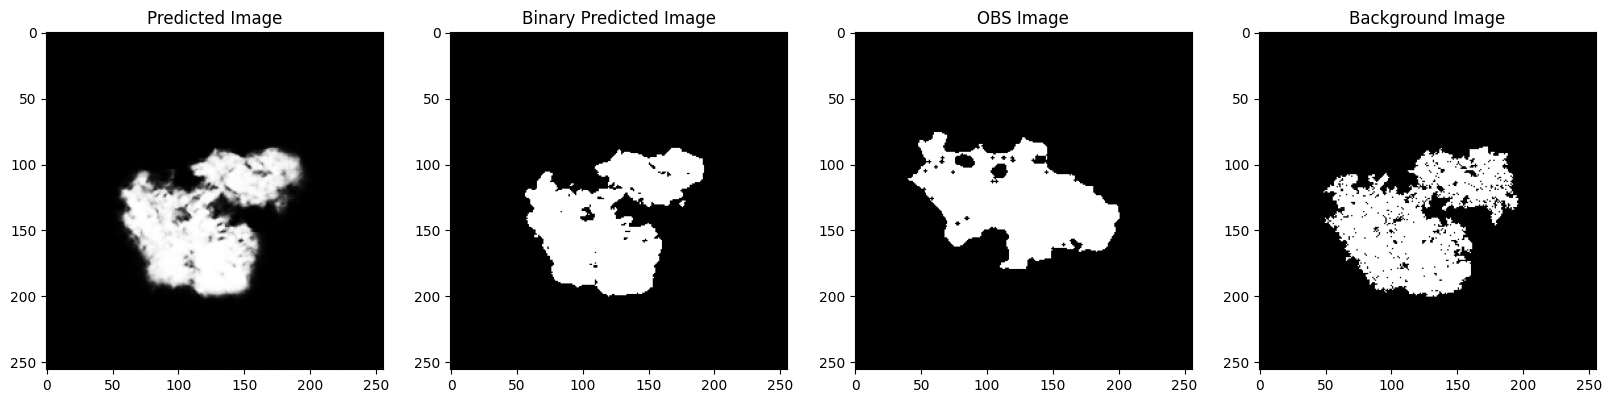

In [ ]:
model_path = 'cae_attn_lstm_model.pth'
input_shape = (4, 256, 256)
lstm_hidden_size = 128
predict_and_plot(model_path, input_shape, lstm_hidden_size)

Comparing the result of this model structure with the former one, we could not tell a big difference in the image aspect, yet we could see slightly difference in the mse aspect. The mse between prediction and corresponding background data are slightly higher (0.0241 -> 0.0237) than that in the former model. This means we could actually use these two structures as we like since there are no big difference in neither numerical value nor image aspect. Hence, we suggest use both of the prediction image to do data assimilation and check their performance in terms of SSIM and other indexes in task 3. Then determine the most suitable model in the end.

### Data assimilation result using the original cae model (without flattened latent space)

because in this model structure, the output of encoder is not in a one dimension latent space, we cannot perform convariance matrix to the size of 256 $\times$ 256 directly, because this will cause kernel crash for calculating such a gigantic matrix. Therefore, we also have to train a PCA within this process because we need to compress information in matrix size of 256 $\times$ 256, 256 $\times$ 256 into much smaller diagonal matrix. But the result is not good because we believe this does not have physical meaning in training a new PCA model and extracting information on cae.

In [ ]:
def encode_images(model, images):
    with torch.no_grad():
        encoded_images = model.cae.encoder(torch.tensor(images, dtype=torch.float32).view(-1, 1, 256, 256))
        return encoded_images.view(len(images), -1).numpy()

def predict_image(model, background):
    input_data = background[:4].reshape((1, 4, 256, 256))
    input_tensor = torch.tensor(input_data, dtype=torch.float32)
    with torch.no_grad():
        encoded_features = model.cae.encoder(input_tensor.view(-1, 1, 256, 256))
        encoded_features = encoded_features.view(1, 4, -1)
        predicted_features = model.lstm(encoded_features)
        predicted_features_reshaped = predicted_features.view(-1, 64, 32, 32)
        predicted_image = model.cae.decoder(predicted_features_reshaped)
        return predicted_image.view(256, 256).numpy()

def pca_transform(encoder_output, n_components=5):
    pca = PCA(n_components=n_components)
    return pca, pca.fit_transform(encoder_output)

Background shape: (5, 256, 256)
Obs shape: (5, 256, 256)
Encoded features shape: torch.Size([4, 64, 32, 32])
Reshaped encoded features shape: torch.Size([1, 4, 65536])
Predicted features shape from LSTM: torch.Size([1, 65536])
Predicted features reshaped for decoder: torch.Size([1, 64, 32, 32])
Predicted image shape after decoder: torch.Size([1, 1, 256, 256])
All images shape for encoding: (5, 1, 256, 256)
All encoded features shape: (5, 65536)
Obs encoded features shape: (5, 65536)
All encoded PCA features shape: (5, 5)
Obs encoded PCA features shape: (5, 5)
Covariance matrix shape: (5, 5)
Kalman gain shape: (5, 5)
Assimilated PCA encoded shape: (5,)
Assimilated encoded shape: (65536,)
Assimilated image shape: (256, 256)
Mean Squared Error between predict and obs before assimilation: 0.10429968517387275
Mean Squared Error between predict and obs after assimilation: 0.24504629607050357


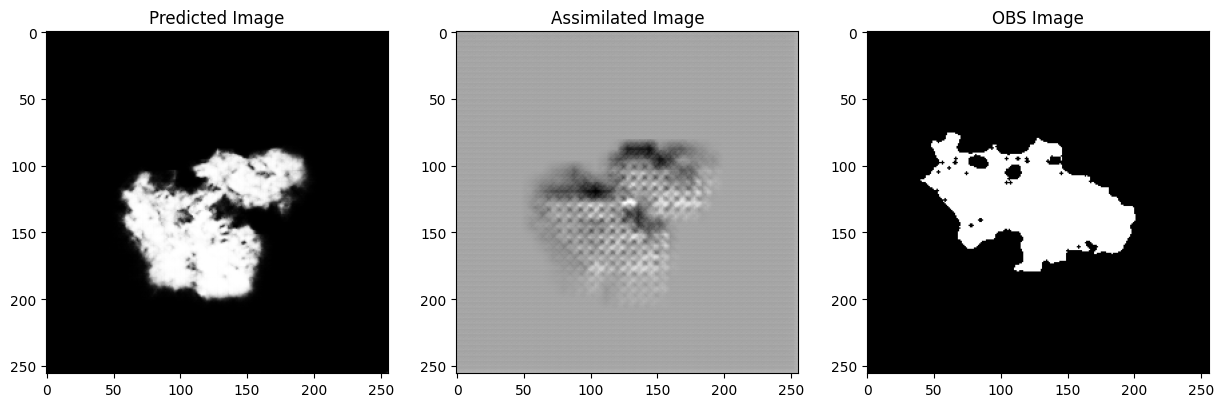

In [ ]:
# kalman filter related function 
def covariance_matrix(X):
    means = np.mean(X, axis=1, keepdims=True)
    dev_matrix = X - means
    res = np.dot(dev_matrix, dev_matrix.T) / (X.shape[1] - 1)
    return res

def update_prediction(x, K, H, y):
    return x + np.dot(K, (y - np.dot(H, x)))

def KalmanGain(B, H, R):
    return np.dot(B, np.dot(H.T, inv(R + np.dot(H, np.dot(B, H.T)))))

input_shape = (4, 256, 256)
lstm_hidden_size = 128
model_path = 'cae_attn_lstm_model.pth'
model, background, obs = load_model_and_data(model_path, input_shape, lstm_hidden_size)

print(f"Background shape: {background.shape}")
print(f"Obs shape: {obs.shape}")
predicted_image = predict_image(model, background)

background_images = background[:4].reshape(-1, 1, 256, 256)
predicted_image_expanded = predicted_image.reshape(1, 1, 256, 256)
all_images = np.vstack((background_images, predicted_image_expanded))
print(f"All images shape for encoding: {all_images.shape}")
all_encoded = encode_images(model, all_images)
    
obs_images = obs[:5].reshape(-1, 1, 256, 256)
obs_encoded = encode_images(model, obs_images)

pca, all_encoded_pca = pca_transform(all_encoded)
obs_encoded_pca = pca.transform(obs_encoded)

B = covariance_matrix(all_encoded_pca.T)
H = np.eye(all_encoded_pca.shape[1])
R = np.eye(all_encoded_pca.shape[1]) * 0.1
K = KalmanGain(B, H, R)

assimilated_encoded_pca = update_prediction(all_encoded_pca[-1], K, H, obs_encoded_pca[-1])
assimilated_encoded = pca.inverse_transform(assimilated_encoded_pca)

assimilated_encoded_tensor = torch.tensor(assimilated_encoded, dtype=torch.float32).view(-1, 64, 32, 32)
with torch.no_grad():
    assimilated_image = model.cae.decoder(assimilated_encoded_tensor).view(256, 256).numpy()

mse_pred_obs_before = mean_squared_error(obs[4].flatten(), predicted_image.flatten())
mse_pred_obs_after = mean_squared_error(obs[4].flatten(), assimilated_image.flatten())

print(f'Mean Squared Error between predict and obs before assimilation: {mse_pred_obs_before}')
print(f'Mean Squared Error between predict and obs after assimilation: {mse_pred_obs_after}')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(predicted_image, cmap='gray')
axes[0].set_title('Predicted Image')

axes[1].imshow(assimilated_image, cmap='gray')
axes[1].set_title('Assimilated Image')

axes[2].imshow(obs[4], cmap='gray')
axes[2].set_title('OBS Image')

plt.show()

The data assimilation result of using 2D latent space CAE is depicted as the middle image. This is not a good result but this is expected as the covariance matrix is a 5 $ \times $ 5 matrix, compared with the original size of 256 $ \times $ 256, barely did sufficient information exists in the latent space to conduct data assimilation. Therefore, it can also be expected that the mses of data assimilation result could be worse than that before assimialtion.

### ConvLSTM Model (Version 1)

In [ ]:
import torch.nn.functional as F

class ConvLSTM(nn.Module):
    def __init__(self, n_previous=2):
        super(ConvLSTM, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)    # Define the first convolutional layer
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)  # Define the second convolutional layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)    # Define the max pooling layer
        self.lstm = nn.LSTM(32 * 64 * 64, 128, batch_first=True)    # Define the LSTM layer
        self.fc1 = nn.Linear(128, 64)   # Define the first fully connected layer
        self.fc2 = nn.Linear(64, 256 * 256)    # Define the second fully connected layer
        self.n_previous = n_previous    # Define the number of previous frames to consider

    def forward(self, x):
        # Get the batch size from the input
        batch_size = x.size(0)
        c_in = x.view(batch_size * self.n_previous, 1, 256, 256)    # Reshape the input
        c_out = self.pool(F.relu(self.conv1(c_in)))   # Pass the input through the first convolutional layer and the pooling layer
        c_out = self.pool(F.relu(self.conv2(c_out)))       # Pass the output of the first convolutional layer through the second convolutional layer and the pooling layer
        c_out = c_out.view(batch_size, self.n_previous, -1)   # Reshape the output
        lstm_out, _ = self.lstm(c_out)
        lstm_out = lstm_out[:, -1, :]
        fc_out = F.relu(self.fc1(lstm_out))
        fc_out = self.fc2(fc_out)
        fc_out = fc_out.view(batch_size, 1, 256, 256)   # Reshape the output
        return fc_out

# Function to train the model
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        # Iterate over the training data
        for inputs, labels in train_loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        # Calculate average loss for the epoch
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch}/{num_epochs}, Loss: {epoch_loss:.4f}')    # Print the average loss for the epoch

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.cuda(), labels.cuda()   # Move the input and label tensors to the GPU
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

        val_loss /= len(val_loader.dataset)
        print(f'Validation Loss: {val_loss:.4f}')   # Print the validation loss for the epoch

# Function to test the model
def test_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.cuda(), labels.cuda()   # Move the input and label tensors to the GPU
            outputs = model(inputs)  # Get the model's output
            loss = criterion(outputs, labels)   # Calculate the loss
            test_loss += loss.item() * inputs.size(0)

    test_loss /= len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}')

#### training with (batch_size=32)

In [ ]:
# Create DataLoader objects for training, validation, and testing datasets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)   # Training DataLoader with batch size of 32 and shuffling enabled
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)   # Validation DataLoader with batch size of 32 and shuffling disabled
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)    # Testing DataLoader with batch size of 32 and shuffling disabled

# Instantiate the model, define the loss function and the optimizer
model_32 = ConvLSTM(n_previous=2).cuda()
criterion = nn.MSELoss()
optimizer = optim.Adam(model_32.parameters(), lr=0.001)

# Train the model with the training and validation data
train_model(model_32, train_loader, val_loader, criterion, optimizer, num_epochs=15)

# Test the model with the test data
test_model(model_32, test_loader, criterion)

Epoch 0/15, Loss: 0.0422
Validation Loss: 0.0306
Epoch 1/15, Loss: 0.0263
Validation Loss: 0.0244
Epoch 2/15, Loss: 0.0206
Validation Loss: 0.0182
Epoch 3/15, Loss: 0.0166
Validation Loss: 0.0161
Epoch 4/15, Loss: 0.0150
Validation Loss: 0.0148
Epoch 5/15, Loss: 0.0142
Validation Loss: 0.0144
Epoch 6/15, Loss: 0.0139
Validation Loss: 0.0142
Epoch 7/15, Loss: 0.0137
Validation Loss: 0.0140
Epoch 8/15, Loss: 0.0134
Validation Loss: 0.0137
Epoch 9/15, Loss: 0.0132
Validation Loss: 0.0135
Epoch 10/15, Loss: 0.0129
Validation Loss: 0.0133
Epoch 11/15, Loss: 0.0128
Validation Loss: 0.0131
Epoch 12/15, Loss: 0.0127
Validation Loss: 0.0131
Epoch 13/15, Loss: 0.0126
Validation Loss: 0.0130
Epoch 14/15, Loss: 0.0126
Validation Loss: 0.0130
Test Loss: 0.0132


#### training with (batch_size=64)

In [ ]:
# Create DataLoader objects for training, validation, and testing datasets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)   # Training DataLoader with batch size of 64 and shuffling enabled
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)   # Validation DataLoader with batch size of 64 and shuffling disabled
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)    # Testing DataLoader with batch size of 64 and shuffling disabled

# Instantiate the model, define the loss function and the optimizer
model_64 = ConvLSTM(n_previous=2).cuda()
criterion = nn.MSELoss()
optimizer = optim.Adam(model_64.parameters(), lr=0.001)

# Train the model with the training and validation data
train_model(model_64, train_loader, val_loader, criterion, optimizer, num_epochs=15)

# Test the model with the test data
test_model(model_64, test_loader, criterion)

Epoch 0/15, Loss: 0.0488
Validation Loss: 0.0371
Epoch 1/15, Loss: 0.0301
Validation Loss: 0.0262
Epoch 2/15, Loss: 0.0248
Validation Loss: 0.0235
Epoch 3/15, Loss: 0.0212
Validation Loss: 0.0191
Epoch 4/15, Loss: 0.0178
Validation Loss: 0.0174
Epoch 5/15, Loss: 0.0169
Validation Loss: 0.0168
Epoch 6/15, Loss: 0.0162
Validation Loss: 0.0158
Epoch 7/15, Loss: 0.0153
Validation Loss: 0.0151
Epoch 8/15, Loss: 0.0148
Validation Loss: 0.0146
Epoch 9/15, Loss: 0.0143
Validation Loss: 0.0142
Epoch 10/15, Loss: 0.0140
Validation Loss: 0.0140
Epoch 11/15, Loss: 0.0137
Validation Loss: 0.0137
Epoch 12/15, Loss: 0.0135
Validation Loss: 0.0134
Epoch 13/15, Loss: 0.0132
Validation Loss: 0.0132
Epoch 14/15, Loss: 0.0130
Validation Loss: 0.0130
Test Loss: 0.0134


#### Save the model

In [ ]:
model_save_path = 'cnn_lstm_model.pth'  # Define the path to save the model
torch.save(model_32.state_dict(), model_save_path)  # Save the model's state dictionary to the specified path

model_save_path = 'cnn_lstm_model.pth'  # Define the path to save the model
torch.save(model_64.state_dict(), model_save_path)  # Save the model's state dictionary to the specified path

#### Prediction and MSE

In [ ]:
def save_model(model, path):
    torch.save(model.state_dict(), path)

def load_model(model, path):
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

def binarize_image(image, threshold=0.47):
    return (image > threshold).astype(np.float32)

def calculate_mse(pred, target):
    criterion = nn.MSELoss()
    return criterion(pred, target).item()

def plot_images(background_last, observation_last, predicted):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(background_last.squeeze(), cmap='gray')
    axes[0].set_title('Background Last Image')

    axes[1].imshow(observation_last.squeeze(), cmap='gray')
    axes[1].set_title('Observation Last Image')

    axes[2].imshow(predicted.squeeze(), cmap='gray')
    axes[2].set_title('Predicted Image')

    plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error

model_32 = CNNLSTM(n_previous=2).cuda()
model_32 = load_model(model_32, 'cnn_lstm_model.pth')

model_64 = CNNLSTM(n_previous=2).cuda()
model_64 = load_model(model_64, 'cnn_lstm_model.pth')

background= np.load('/content/drive/My Drive/objective_2/Ferguson_fire_background.npy')
observation = np.load('/content/drive/My Drive/objective_2/Ferguson_fire_obs.npy')

#### Comparison in different sliding windows (n_previous)

##### n_previous = 4

Compare the last image.

MSE between predicted image and observation last image: 0.1224
MSE between predicted image and background last image: 0.0299


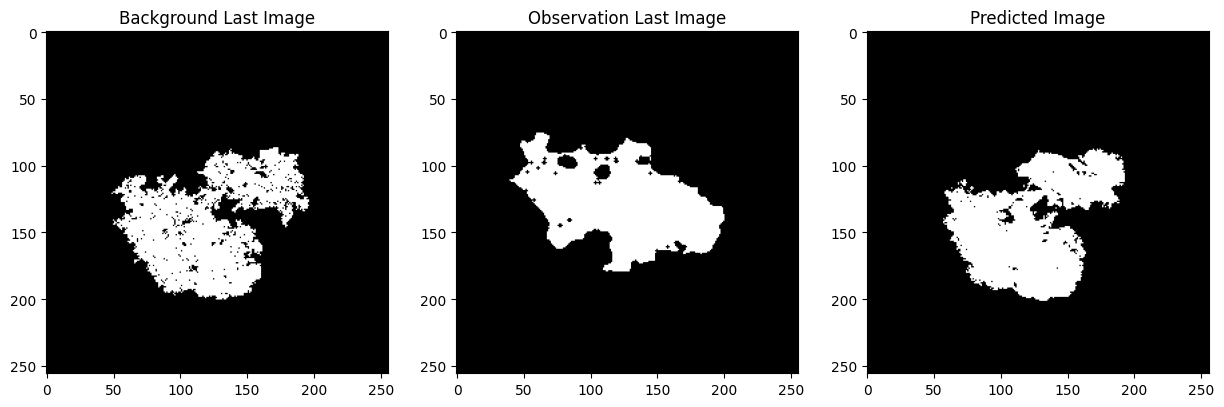

In [ ]:
background_input = torch.tensor(background[:4]).unsqueeze(0).cuda().float()  # (1, 4, 256, 256)
predicted = model_32(background_input).detach().cpu().numpy().squeeze()  # (256, 256)
predicted_binarized = binarize_image(predicted)
mse_value_obs = calculate_mse(torch.tensor(predicted_binarized).unsqueeze(0), torch.tensor(observation[4]).unsqueeze(0))  # Calculate the MSE between the predicted image and the observation last image
print(f'MSE between predicted image and observation last image: {mse_value_obs:.4f}')   # Print the MSE value

mse_value_bk = calculate_mse(torch.tensor(predicted_binarized).unsqueeze(0), torch.tensor(background[4]).unsqueeze(0))
print(f'MSE between predicted image and background last image: {mse_value_bk:.4f}')   # Print the MSE value

plot_images(background[4], observation[4], predicted_binarized)       # Plot the background last image, observation last image, and the predicted image

##### n_previous = 2

Use 2 images to predict the next, thus generating 3 predicted images.

MSE between predicted image and observation third image: 0.0793
MSE between predicted image and background third image: 0.0228


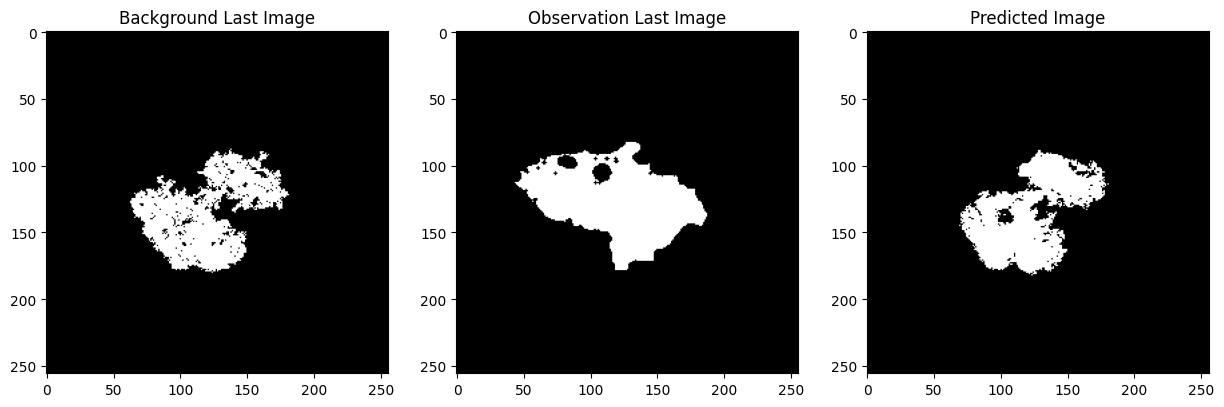

In [ ]:
# compare the third image
background_input_2s_1 = torch.tensor(background[:2]).unsqueeze(0).cuda().float()  # (1, 4, 256, 256)
predicted_2s_1 = model_32(background_input_2s_1).detach().cpu().numpy().squeeze()  # (256, 256)
predicted_binarized_1 = binarize_image(predicted_2s_1)

mse_value_obs_2s_1 = calculate_mse(torch.tensor(predicted_binarized_1).unsqueeze(0), torch.tensor(observation[2]).unsqueeze(0))  # Calculate the MSE between the predicted image and the observation last image
print(f'MSE between predicted image and observation third image: {mse_value_obs_2s_1:.4f}')   # Print the MSE value

mse_value_bk_2s_1 = calculate_mse(torch.tensor(predicted_binarized_1).unsqueeze(0), torch.tensor(background[2]).unsqueeze(0))
print(f'MSE between predicted image and background third image: {mse_value_bk_2s_1:.4f}')   # Print the MSE value

plot_images(background[2], observation[2], predicted_binarized_1)       # Plot the background last image, observation last image, and the predicted image

MSE between predicted image and observation fourth image: 0.0980
MSE between predicted image and background fourth image: 0.0276


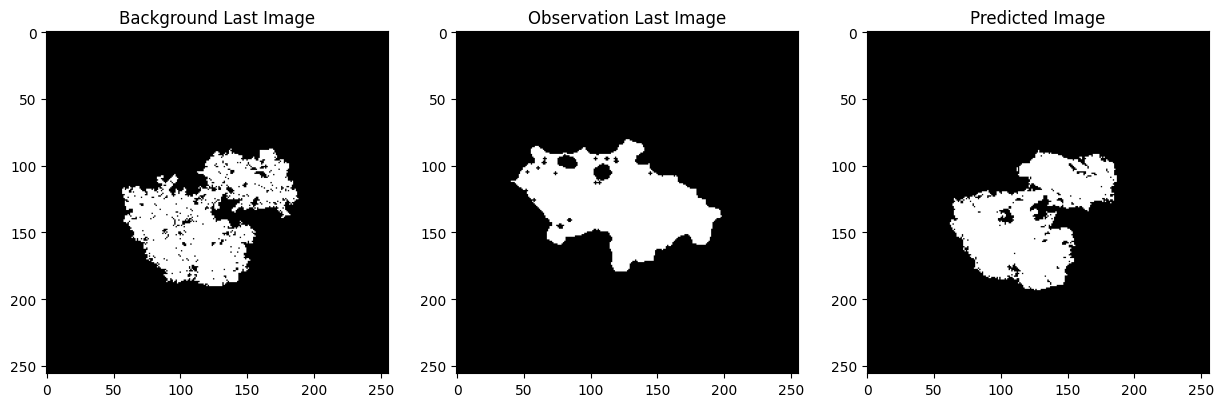

In [ ]:
# compare the fourth image
background_input_2s_2 = torch.tensor(background[1:3]).unsqueeze(0).cuda().float()  # (1, 4, 256, 256)
predicted_2s_2 = model_32(background_input_2s_2).detach().cpu().numpy().squeeze()  # (256, 256)
predicted_binarized_2 = binarize_image(predicted_2s_2)

mse_value_obs_2s_2 = calculate_mse(torch.tensor(predicted_binarized_2).unsqueeze(0), torch.tensor(observation[3]).unsqueeze(0))  # Calculate the MSE between the predicted image and the observation last image
print(f'MSE between predicted image and observation fourth image: {mse_value_obs_2s_2:.4f}')   # Print the MSE value

mse_value_bk_2s_2 = calculate_mse(torch.tensor(predicted_binarized_2).unsqueeze(0), torch.tensor(background[3]).unsqueeze(0))
print(f'MSE between predicted image and background fourth image: {mse_value_bk_2s_2:.4f}')   # Print the MSE value

plot_images(background[3], observation[3], predicted_binarized_2)       # Plot the background last image, observation last image, and the predicted image

MSE between predicted image and observation fourth image: 0.1254
MSE between predicted image and background fourth image: 0.0325


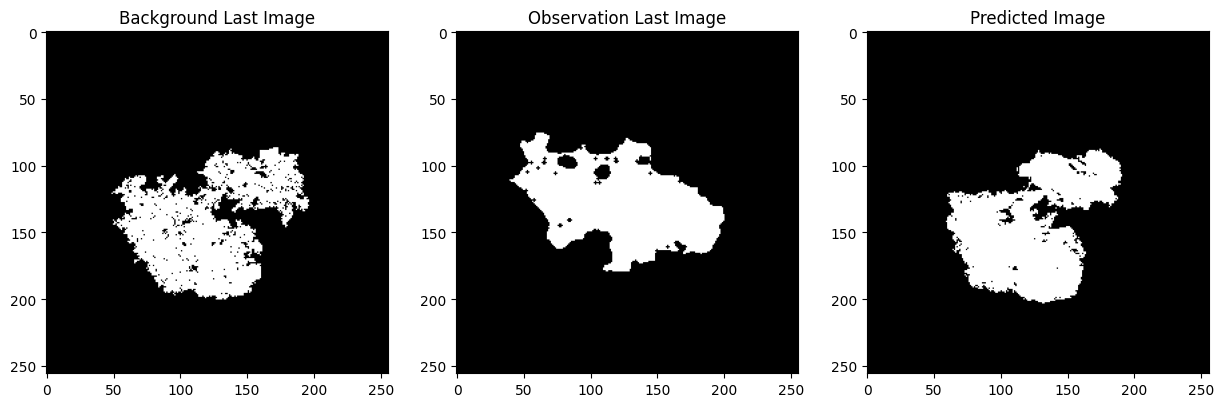

In [ ]:
# compare the last image
background_input_2s_3 = torch.tensor(background[2:4]).unsqueeze(0).cuda().float()  # (1, 4, 256, 256)
predicted_2s_3 = model_32(background_input_2s_3).detach().cpu().numpy().squeeze()  # (256, 256)
predicted_binarized_3 = binarize_image(predicted_2s_3)

mse_value_obs_2s_3 = calculate_mse(torch.tensor(predicted_binarized_3).unsqueeze(0), torch.tensor(observation[4]).unsqueeze(0))  # Calculate the MSE between the predicted image and the observation last image
print(f'MSE between predicted image and observation fourth image: {mse_value_obs_2s_3:.4f}')   # Print the MSE value

mse_value_bk_2s_3 = calculate_mse(torch.tensor(predicted_binarized_3).unsqueeze(0), torch.tensor(background[4]).unsqueeze(0))
print(f'MSE between predicted image and background fourth image: {mse_value_bk_2s_3:.4f}')   # Print the MSE value

plot_images(background[4], observation[4], predicted_binarized_3)       # Plot the background last image, observation last image, and the predicted image

The predicted three images are dynamic, and they correctly predict the trend of expansion, with a relatively low MSE compared to the original image. However, they perform inferiorly to the final model.

#### Batch tune (32 -> 64)

MSE between predicted image and observation third image: 0.1085
MSE between predicted image and background third image: 0.0446


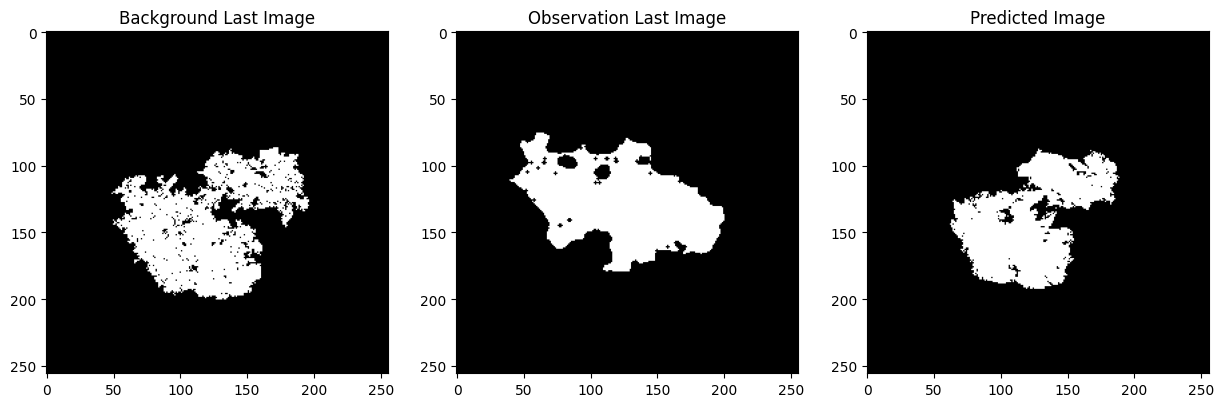

In [ ]:
background_input_2s64_1 = torch.tensor(background[2:4]).unsqueeze(0).cuda().float()  # (1, 4, 256, 256)
predicted_2s64_1 = model_64(background_input_2s64_1).detach().cpu().numpy().squeeze()  # (256, 256)
predicted_binarized_64 = binarize_image(predicted_2s_3)
mse_value_obs_2s64_1 = calculate_mse(torch.tensor(predicted_binarized_64).unsqueeze(0), torch.tensor(observation[4]).unsqueeze(0))  # Calculate the MSE between the predicted image and the observation last image
print(f'MSE between predicted image and observation last image: {mse_value_obs_2s64_1:.4f}')   # Print the MSE value

mse_value_bk_2s64_1 = calculate_mse(torch.tensor(predicted_binarized_64).unsqueeze(0), torch.tensor(background[4]).unsqueeze(0))
print(f'MSE between predicted image and background last image: {mse_value_bk_2s64_1:.4f}')   # Print the MSE value

plot_images(background[4], observation[4], predicted_binarized_64)       # Plot the background last image, observation last image, and the predicted image

It can be observed that after increasing the batch size, the MSE increases and the predicted image's wildfire area shrinks.

#### Hyperparameters

1. Hidden Layer: A hidden size of 128 provides enough neurons to capture and represent complex temporal dependencies and patterns in the data. This is particularly important for tasks that require understanding long-term dependencies. While larger hidden sizes can lead to overfitting, especially with limited data, a size of 128 helps to generalize better on unseen data. It offers a balance between model capacity and the ability to generalize. By considering the practicality, using 128 hidden layers is very ease for training. Models with a hidden size of 128 are easier and faster to train compared to those with larger hidden sizes. This makes hyperparameter tuning and iterative experimentation more manageable.

2. Batch Size: By comparing the results above, MSE is bigger when batch size is equal to 64. The training dataset has been shuffled before training to prevent over learning for the model. Usually smaller batch sizes introduce more noise into the gradient estimates, which can help the model escape local minima and find better solutions in the loss landscape. This stochasticity can act as a regularizer, helping to improve generalization. With a batch size of 32, this noise is balanced, but with 64, it might be reduced too much, leading to poorer generalization. Also, larger batch sizes require more memory, which can limit the ability to train on larger models or higher resolution inputs. And if I set my batch size into 100 (Assumption: i want to match with the wildfire catagory), my GPU SAM crushed directly. If the batch size is too small, machine learning might not learn the data very well and probably study some random features change (shuffle training dataset) that lead to underfitting.

3. Using n_previous = 2 instead of n_previous = 4 could be better because it maintains a higher temporal resolution, focuses on the most relevant recent frames, reduces model complexity, and makes more efficient use of the available training data. This is particularly important in scenarios with rapid changes, such as wildfire progression, where the latest frames are often the most predictive of the immediate future. Another reason of why choose n_previous = 2 in the end because our group want to use three predicted images for data assimilation in task three.